In [137]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os.path


from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [138]:
#Samaras Laptop
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\DIE_DATEN\datensatz.csv')
#song_data = song_data[(song_data['Language'] == 'en')]
#song_data.to_csv("outData.csv", index=False)
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\outData.csv')


#Anjas Laptop
# song_data = pd.read_csv('../Daten/train.csv')
# song_data = song_data[(song_data['Language'] == 'en')]
# song_data.to_csv("../Daten/outData.csv", index=False)
song_data = pd.read_csv('../Daten/cleanedData.csv')

This was done using : https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/

## Get a balanced sample of 5 songs per genre

In [139]:
num_genres = song_data.Genre.nunique()
num_topics = num_genres
genres = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Metal', 'Pop', 'R&B', 'Rock']
topic_columns = [i for i in range(0, num_topics)]

In [140]:
song_data = song_data[["Genre", "Lyrics"]]
song_data = song_data.groupby('Genre').sample(1000, random_state=42).reset_index(drop=True)
song_data.head(10)

,Genre,Lyrics
0,Country,IF YOU'RE GOIN' GIRL WRITER BOBBY BOND If you'...
1,Country,I'd rather live a life of lies and fantasy Tha...
2,Country,Well I'm making out my list For ole St.Nick to...
3,Country,Though you've gone away I play your favorite s...
4,Country,"DADDY'S LITTLE GIRL Writers Bobby Burke, Horac..."
5,Country,SANTA HO HO HO HO HO hohohohohohoho And what d...
6,Country,In a tiny town where the biggest things Were t...
7,Country,"(I sit here and look at you, lonely room it's ..."
8,Country,I've got this sensitive condition It's aggriva...
9,Country,"I'm traveling down this lonesome road, oh, how..."


## Data Preprocessing

In [141]:
song_data_processed = song_data.copy()
# removing everything except alphabets`
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].str.replace("[^a-zA-Z#]", " ")
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].str.replace("\'", " ")
# removing short words (shorter than 3 characters)
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].apply(lambda x: x.lower())
song_data_processed

,Genre,Lyrics
0,Country,goin girl writer bobby bond goin girl summerti...
1,Country,rather live life lies fantasy than face truth ...
2,Country,well making list st.nick tonight afraid what w...
3,Country,though gone away play your favorite song blue ...
4,Country,"daddy little girl writers bobby burke, horace ..."
...,...,...
9995,Rock,used sailor sailed across seas just island sin...
9996,Rock,could look beyond your face photograph your hi...
9997,Rock,they come they when they want wait turn want k...
9998,Rock,getting dark here want leave shadow falling be...


In [142]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
new_stop_words = ['ooh','oh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa', 'intro', 'chorus', 'bridge', 'refrain']
stop_words.extend(new_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [143]:
# tokenization
song_data_processed['Tokens'] = song_data_processed['Lyrics'].apply(lambda x: x.split())

# remove stop-words
song_data_processed['Tokens'] = song_data_processed['Tokens'].apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(song_data_processed)):
    t = ' '.join(song_data_processed['Tokens'][i])
    detokenized_doc.append(t)

song_data_processed['CleanLyrics'] = detokenized_doc
song_data_processed

,Genre,Lyrics,Tokens,CleanLyrics
0,Country,goin girl writer bobby bond goin girl summerti...,"[goin, girl, writer, bobby, bond, goin, girl, ...",goin girl writer bobby bond goin girl summerti...
1,Country,rather live life lies fantasy than face truth ...,"[rather, live, life, lies, fantasy, face, trut...",rather live life lies fantasy face truth reali...
2,Country,well making list st.nick tonight afraid what w...,"[well, making, list, st.nick, tonight, afraid,...",well making list st.nick tonight afraid want y...
3,Country,though gone away play your favorite song blue ...,"[though, gone, away, play, favorite, song, blu...",though gone away play favorite song blue gold ...
4,Country,"daddy little girl writers bobby burke, horace ...","[daddy, little, girl, writers, bobby, burke,, ...","daddy little girl writers bobby burke, horace ..."
...,...,...,...,...
9995,Rock,used sailor sailed across seas just island sin...,"[used, sailor, sailed, across, seas, island, s...",used sailor sailed across seas island since to...
9996,Rock,could look beyond your face photograph your hi...,"[could, look, beyond, face, photograph, hidden...",could look beyond face photograph hidden place...
9997,Rock,they come they when they want wait turn want k...,"[come, want, wait, turn, want, know, learned, ...",come want wait turn want know learned hitchhik...
9998,Rock,getting dark here want leave shadow falling be...,"[getting, dark, want, leave, shadow, falling, ...",getting dark want leave shadow falling believe...


## Document-Term Matrix

In [144]:
vectorizer = TfidfVectorizer(stop_words=new_stop_words, 
                             max_features= 2000, # keep top 1000 terms 
                             max_df = 0.05, 
                             smooth_idf=True)

X = vectorizer.fit_transform(song_data_processed['CleanLyrics'])

X.shape # check shape of the document-term matrix

(10000, 2000)

### Topic Modeling

In [145]:
# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=num_topics, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(X)

TruncatedSVD(n_components=10, n_iter=100, random_state=122)

In [146]:
terms = vectorizer.get_feature_names_out()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ", end='')
    for t in sorted_terms:
        print(t[0], end=' ')
    print('')

Topic 0: niggas bitch lord dance lonely heaven verse sometimes round rain 
Topic 1: niggas bitch bitches verse fuckin hoes niggaz fucking what hood 
Topic 2: lord heaven jesus death blood shall niggas pray born holy 
Topic 3: dance lord heaven music rock jesus round dancing chance knows 
Topic 4: christmas year merry white snow bells stars happy santa bright 
Topic 5: alright lord woman christmas happy miss honey lady loving darling 
Topic 6: alright christmas round blood rock death ready fear merry control 
Topic 7: goodbye lord christmas dance tomorrow fool hurt easy friend anymore 
Topic 8: beautiful thinking lord christmas way chance somebody pretty running all 
Topic 9: miss heaven happy wanted dance christmas sometimes anything control death 


### Append Topics to DF

In [147]:
X_topics = svd_model.fit_transform(X)
doc_top_df = pd.DataFrame(X_topics, columns = [i for i in range(0, num_topics)])
results = pd.merge(song_data, doc_top_df, left_index=True, right_index=True)
#Evaluate most dominant Topics
results['Dominant_Topic'] = results[[i for i in range(0, num_topics)]].idxmax(axis=1)
results

,Genre,Lyrics,0,1,2,3,4,5,6,7,8,9,Dominant_Topic
0,Country,IF YOU'RE GOIN' GIRL WRITER BOBBY BOND If you'...,0.089495,0.014753,-0.001298,0.025769,0.038521,0.022279,0.019733,-0.015398,-0.007028,-0.064077,0
1,Country,I'd rather live a life of lies and fantasy Tha...,0.134038,-0.071007,-0.036368,-0.065462,-0.059057,-0.023385,-0.028616,0.130422,0.025265,-0.040848,0
2,Country,Well I'm making out my list For ole St.Nick to...,0.036483,-0.018756,-0.009073,0.005308,0.191195,0.068261,0.071574,0.045214,0.028449,0.032275,4
3,Country,Though you've gone away I play your favorite s...,0.056273,-0.017956,-0.001968,0.000659,0.026757,-0.011965,-0.018279,-0.006621,-0.019606,-0.034953,0
4,Country,"DADDY'S LITTLE GIRL Writers Bobby Burke, Horac...",0.093668,-0.026131,0.027857,0.023482,0.195034,0.067204,0.043290,-0.000382,0.014994,-0.019780,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Rock,i used to be a sailor\nwho sailed across the s...,0.049827,-0.019076,0.002734,-0.006899,0.007613,-0.030288,-0.002064,0.004454,-0.008405,-0.010922,0
9996,Rock,If I could look beyond your face \nAnd photogr...,0.103971,-0.060603,-0.017815,-0.059170,-0.007102,0.068934,-0.040300,0.013549,0.003844,0.090458,0
9997,Rock,They come and they go when they want me\nI sit...,0.111730,0.014954,0.006701,0.007125,0.011966,-0.026046,0.031207,0.002241,-0.004840,-0.016530,0
9998,Rock,It's getting dark in here\nDon't want to leave...,0.108462,-0.065989,-0.007521,-0.054538,0.000815,-0.028837,-0.010656,0.009037,-0.011639,-0.018081,0


### Explore Results

#### Crosstab

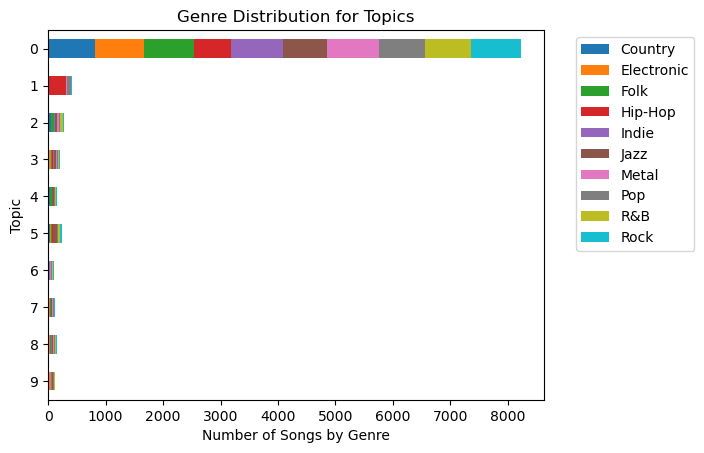

In [162]:
# Create a crosstab
crosstab = pd.crosstab(results['Dominant_Topic'], results['Genre']).sort_values(by="Dominant_Topic", ascending=False)

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Topic')
plt.title('Genre Distribution for Topics')
plt.show()

In [163]:
crosstab

Genre,Country,Electronic,Folk,Hip-Hop,Indie,Jazz,Metal,Pop,R&B,Rock
Dominant_Topic,,,,,,,,,,
9,16,28,8,5,11,12,9,14,10,12
8,14,22,12,5,17,20,6,22,15,16
7,19,10,12,1,6,21,19,12,8,14
6,6,3,3,8,14,4,15,12,18,19
5,36,18,18,5,14,57,3,19,40,25
4,24,6,29,4,7,29,1,15,26,8
3,22,32,18,7,18,41,10,23,22,12
2,43,14,37,15,15,36,25,14,57,28
1,1,14,2,292,5,4,5,71,12,1


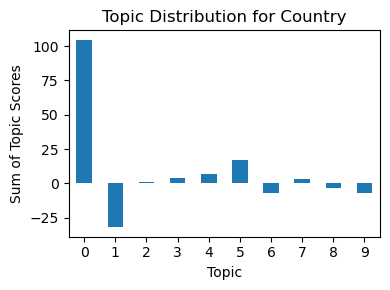

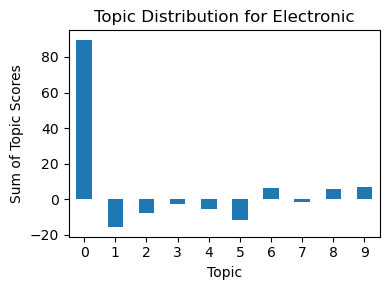

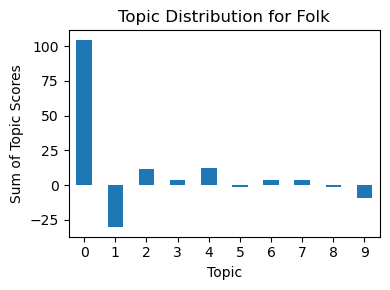

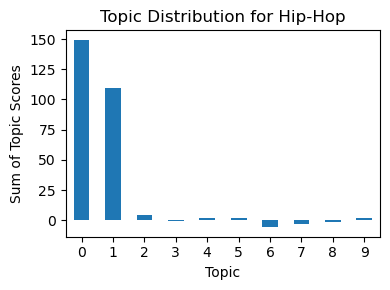

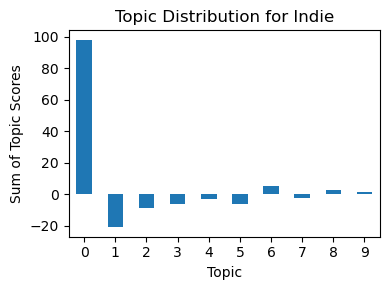

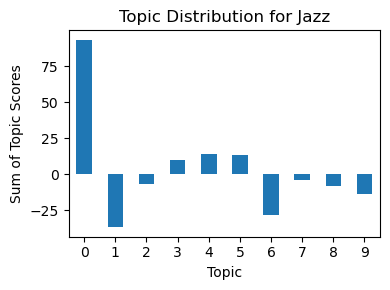

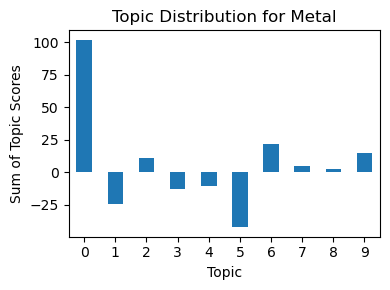

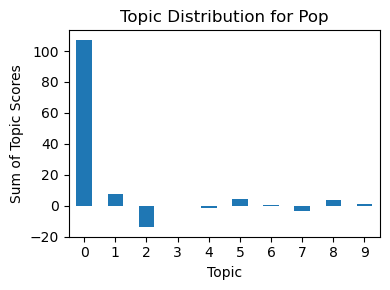

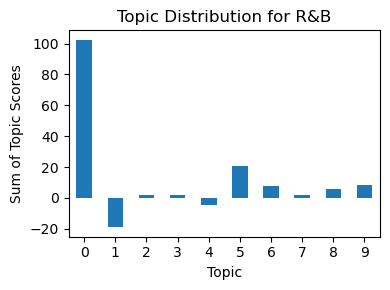

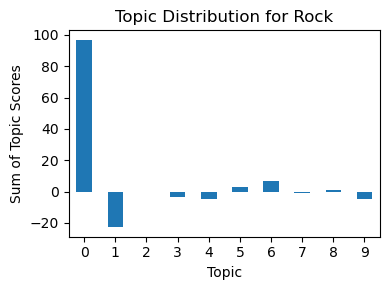

In [150]:
#Evaluate how many topics genres typically appear in (by summing up all the topic values instead of only looking at the most dominant one)
for genre in genres:
    plt.figure(figsize=(4,3))
    results[results['Genre'] == genre][topic_columns].sum(axis=0).plot(kind='bar')
    plt.title(f'Topic Distribution for ' + genre)
    plt.xlabel('Topic')
    plt.ylabel('Sum of Topic Scores')
    plt.xticks(rotation=0)  # Rotate x-labels for better readability
    plt.tight_layout()
    plt.show()

#### Visualization (PCA) (visualizing LDA Results)

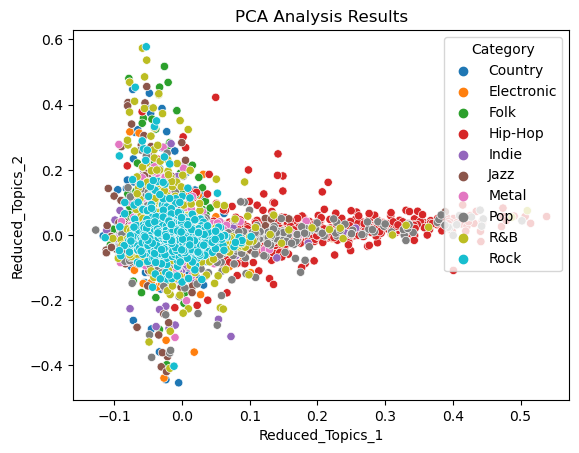

In [151]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(results[[i for i in range(0, num_topics)]])
results[['Reduced_Topics_1', 'Reduced_Topics_2']] = reduced
#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Genre', data=results)
plt.title('PCA Analysis Results')
plt.legend(title='Category')
plt.show()

### Using Clustering

In [152]:
kmeans = KMeans(n_clusters=num_genres, random_state=0).fit(results[[i for i in range(0, num_topics)]])
results["Cluster"] = kmeans.labels_
results

c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Genre,Lyrics,0,1,2,3,4,5,6,7,8,9,Dominant_Topic,Reduced_Topics_1,Reduced_Topics_2,Cluster
0,Country,IF YOU'RE GOIN' GIRL WRITER BOBBY BOND If you'...,0.089495,0.014753,-0.001298,0.025769,0.038521,0.022279,0.019733,-0.015398,-0.007028,-0.064077,0,0.018346,-0.001647,7
1,Country,I'd rather live a life of lies and fantasy Tha...,0.134038,-0.071007,-0.036368,-0.065462,-0.059057,-0.023385,-0.028616,0.130422,0.025265,-0.040848,0,-0.052889,-0.033200,3
2,Country,Well I'm making out my list For ole St.Nick to...,0.036483,-0.018756,-0.009073,0.005308,0.191195,0.068261,0.071574,0.045214,0.028449,0.032275,4,-0.029304,-0.012950,7
3,Country,Though you've gone away I play your favorite s...,0.056273,-0.017956,-0.001968,0.000659,0.026757,-0.011965,-0.018279,-0.006621,-0.019606,-0.034953,0,-0.021612,-0.003020,7
4,Country,"DADDY'S LITTLE GIRL Writers Bobby Burke, Horac...",0.093668,-0.026131,0.027857,0.023482,0.195034,0.067204,0.043290,-0.000382,0.014994,-0.019780,4,-0.020843,0.027082,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Rock,i used to be a sailor\nwho sailed across the s...,0.049827,-0.019076,0.002734,-0.006899,0.007613,-0.030288,-0.002064,0.004454,-0.008405,-0.010922,0,-0.024496,0.001242,7
9996,Rock,If I could look beyond your face \nAnd photogr...,0.103971,-0.060603,-0.017815,-0.059170,-0.007102,0.068934,-0.040300,0.013549,0.003844,0.090458,0,-0.050555,-0.016306,7
9997,Rock,They come and they go when they want me\nI sit...,0.111730,0.014954,0.006701,0.007125,0.011966,-0.026046,0.031207,0.002241,-0.004840,-0.016530,0,0.024288,0.007083,1
9998,Rock,It's getting dark in here\nDon't want to leave...,0.108462,-0.065989,-0.007521,-0.054538,0.000815,-0.028837,-0.010656,0.009037,-0.011639,-0.018081,0,-0.054794,-0.006031,1


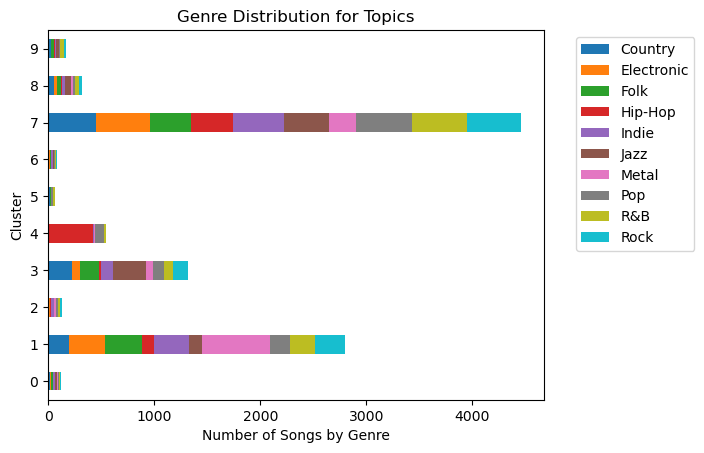

In [153]:
# Create a crosstab
crosstab = pd.crosstab(results['Cluster'], results['Genre'])

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Cluster')
plt.title('Genre Distribution for Topics')
plt.show()

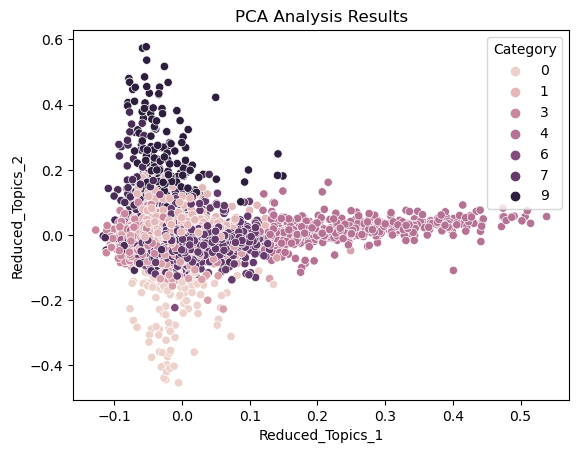

In [154]:
#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Cluster', data=results)
plt.title('PCA Analysis Results')
plt.legend(title='Category')
plt.show()

### Trying to predict the genre based on the topic vector

In [155]:
X = results[[i for i in range(0, num_topics)]]
label_encoder = LabelEncoder()
results["GenreID"] = label_encoder.fit_transform(results["Genre"])
y = results["GenreID"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [156]:
#K-nearest neighbors
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.2683333333333333

In [157]:
#svm classifier
svc = SVC(kernel="linear")
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.262

In [158]:
#Random forest
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.2843333333333333

### Get Classification Matrix (of knn)

In [159]:
y_pred = svc.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.29      0.04      0.07       318
           1       0.18      0.40      0.25       308
           2       0.25      0.20      0.22       288
           3       0.72      0.64      0.68       303
           4       0.00      0.00      0.00       320
           5       0.31      0.38      0.34       290
           6       0.33      0.57      0.42       292
           7       0.21      0.08      0.11       292
           8       0.22      0.06      0.10       324
           9       0.11      0.32      0.17       265

    accuracy                           0.26      3000
   macro avg       0.26      0.27      0.23      3000
weighted avg       0.26      0.26      0.23      3000



c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

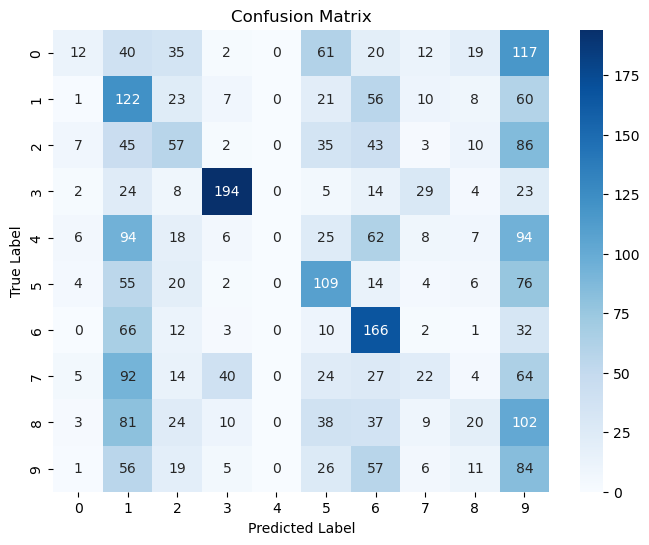

In [160]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the class labels
class_labels = svc.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [161]:
results[["Genre", "GenreID"]].drop_duplicates()

,Genre,GenreID
0,Country,0
1000,Electronic,1
2000,Folk,2
3000,Hip-Hop,3
4000,Indie,4
5000,Jazz,5
6000,Metal,6
7000,Pop,7
8000,R&B,8
9000,Rock,9


### Was hier gemacht wurde:
- Nehmen eines song subsets mit jeweils n songs aus jedem der m genres
- Bereinigen der Lyrics mit verschiedenen Preprocessing methoden (Best Practice)
- Using LSA on the songs (aka Document-Term Matrix + SVD)
- Investigating whether there is a correlation between the topics and the song genres, using crosstabs and, PCA-Scatterplots and Clustering
- Investigating whether it is possible to predict a genre based on its most prominent topics 

### Ergebnis
- Teils Zusammenhang zwischen prominenten Topics und Song Genres
- Vor Allem HipHop Topics fallen auffallend oft in die gleiche Kategorie
- Ergebnisse eindeutiger als bei der Vorherigen Lösung
- Vorhersage des Genres aus Topics nach wie vor nur schlecht möglich, aber nochmal besser als bei der LDA
- Einige Genres wie Folk und Pop sind extrem schwer vorherzusagen, was wohl bedeutet dass hier die Themenbereiche am wenigsten eingeschränkt sind
- Auf dem zweiten Platz ist Metall und Indie, welche auch relativ gut vorhergesagt wird
- Die ergebnisse scheinen allerdings weniger eindeutig zu sein als bei der LDA
- LSI performed bei manchen genres extrem schlecht und bei manchen sehr gut
- Ergebnisse sind abhängig von max-df parameter und der anzahl der terms
- Topic 0 taucht komischerweise extrem oft auf
- Viele Wörter tauchen mehrmals auf in verschiedenen topics

### Interpretation
- Das Model funktioniert bereits besser als das vorherige. Die Vermutung liegt nahe, dass es zwischen manchen Genres mehr Unterschiede als zwischen anderen gibt. Ein gutes beispiel dafür ist HipHop, das sich relativ klar unterscheiden lässt.